In [88]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.special import jn_zeros

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
# Physical parameters
# ======= fixed ==========
L = 1e7 # horizontal length scale; appro radius of polar vortex
T = 9.925*3600  # period of Jupiter rotation
a = 6.99e7 

# ======= derived =========
omega = 2 * np.pi / T 
R = a / L / 2.0   # dimensionless disk radius

# ======= defined/changed ==========
F = 51.8   # L**2/Ld1**2; can vary between 0.1 and 100
U = 100
A1 = 1.0 
Gamma = 2 * omega / a / a * (L**3) / U

In [90]:
Gamma

0.7198176581830783

In [91]:
def Jmk(m, R, n=1):
    # m is azimuthal wavenumber
    # R is the radius of the domain
    x_zeros = jn_zeros(m, n)
    km_n = x_zeros / R
    return km_n

In [92]:
# calculate the radial wavenumber
nk = 15 # radial wavenumber range 
nm = 15 # azimuthal wavenumber range 
m = np.reshape(np.arange(1, nm+1), (nm, 1))
k = np.empty((nm, nk))
for i in m.flatten():
    k[i-1, :] = Jmk(i, R, n=nk)


In [93]:
# a1 * c2 + a2 * c + a3 = 0 to have a solution
a1 = k**4 + 2 * F * (k**2) 
a2 = - 2 * ((k**2) + F) * Gamma
a3 = Gamma**2 - (k**4) + 2 * F * (k**2)

In [94]:
# solve for wave speed and growth rate
c = np.empty(a1.shape + (2,), dtype=np.complex128)

# Loop through each element of the k array
for i in range(a1.shape[0]):
    for j in range(a1.shape[1]):
        
        # Compute roots and store
        c[i, j, :] = np.roots([a1[i,j], a2[i,j], a3[i,j]])

cr = np.real(c)  # shape (m, n, 2)
ci = np.imag(c)


In [95]:
ci[:,:,0]* m

array([[ 0.94310434,  0.95798405,  0.92046246,  0.86803447,  0.80421694,
         0.73047518,  0.64734748,  0.554049  ,  0.44715993,  0.31562498,
         0.08246829,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.93132723,  1.88733696,  1.79590219,  1.67898193,  1.540973  ,
         1.3839394 ,  1.20785127,  1.00909972,  0.77575923,  0.46285492,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 2.88799329,  2.77904657,  2.62112083,  2.42881034,  2.20681342,
         1.95687618,  1.67681863,  1.35676651,  0.96497622,  0.30033192,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 3.81076857,  3.62768664,  3.39177501,  3.11386659,  2.79830487,
         2.44526108,  2.04797917,  1.58392635,  0.97057639,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 4.69699626,  4.42878721,  4.10401918,  3.73070917,  3.31183621,
         2.8441881 ,  2.31246179,  1.66807118, 

In [96]:
ci_growth = ci[:,:,0] # positive; (nm, nk)
cp = cr[:,:,1]

ci_colored = np.where(ci_growth > 1e-6, ci_growth * m, np.nan)  # shape: (nm, nk)
x = k.ravel()                    # k: shape (nm, nk), already gridded
y = m.repeat(k.shape[1], axis=1).ravel()  # m: (nm, 1) → repeat to match shape (nm, nk)
c = ci_colored.ravel()
crp = cp.ravel()

In [97]:
# draw the boundary for the instability
instability = a2**2 - 4 * a1 * a3
thred = 0
plt_ins = instability.ravel()

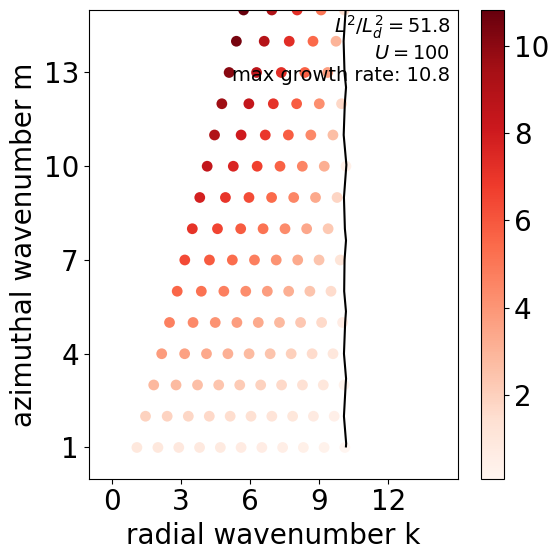

In [98]:
plt.rcParams['font.size'] = 20
# Plot
plt.figure(figsize=(6, 6))
sc = plt.scatter(x, y, c=c, cmap='Reds', edgecolors='none', s=60)
plt.colorbar(sc)
plt.contour(k, m.repeat(k.shape[1], axis=1), instability, levels=[thred], colors='black')
plt.xlabel('radial wavenumber k')
plt.ylabel('azimuthal wavenumber m')
# plt.title('m * ci')
plt.xlim([-1, nk])
plt.ylim([0, nm])
plt.xticks(np.arange(0, nk, 3))
plt.yticks(np.arange(1, nm, 3))
plt.text(
    0.98, 0.84,  # x, y in axes fraction (0–1)
    fr'$L^2/L_d^2 = {F}$' + '\n' +
    fr'$U = {U}$' + '\n' +
    'max growth rate: '+fr'{np.nanmax(c):.3g}',
    ha='right', va='bottom',
    transform=plt.gca().transAxes,
    fontsize=14
)
plt.tight_layout()
plt.show()

In [99]:
cr[:,0,0] * np.arange(1,nm+1)


array([0.30286914, 0.34017941, 0.33409705, 0.31868003, 0.30207489,
       0.28651654, 0.27254915, 0.26018405, 0.24926839, 0.23961191,
       0.23103117, 0.22336349, 0.2164696 , 0.2102322 , 0.20455316])

In [100]:
# total wavenumber vs shear
ci[:,0,0] * np.arange(1,nm+1)


array([ 0.94310434,  1.93132723,  2.88799329,  3.81076857,  4.69699626,
        5.54328334,  6.34605417,  7.10180369,  7.80719105,  8.45906032,
        9.05442451,  9.59042803, 10.06429356, 10.47325478, 10.8144741 ])

In [101]:
max_idx = np.nanargmax(c)

# Get corresponding values
ci_max = c[max_idx]

m_max = y[max_idx]
k_max = x[max_idx]

max_grow = ci_max
print(f"Max growth rate = {max_grow:.4g} at m = {m_max}, k = {k_max:.4g}")



Max growth rate = 10.81 at m = 15, k = 5.721


In [102]:
# Get corresponding values
cr_max = crp[max_idx]
m_max = y[max_idx]
k_max = x[max_idx]

print(f"Max cr = {cr_max:.4g} at m = {m_max}, k = {k_max:.4g}")


Max cr = 0.01364 at m = 15, k = 5.721


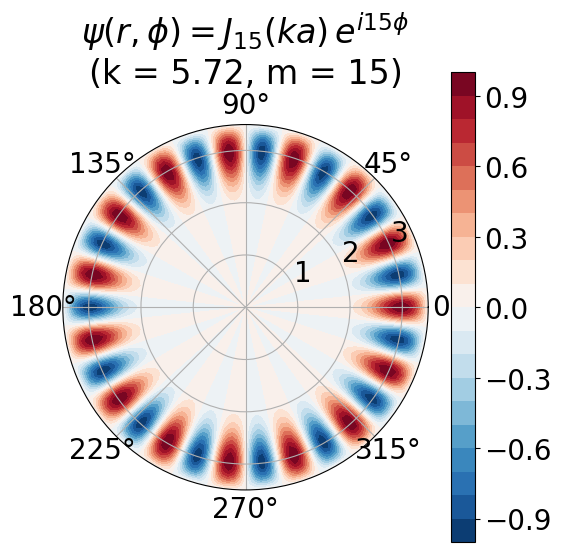

In [103]:
from scipy.special import jv

nr = 200
nphi = 200

r = np.linspace(0, R, nr)
phi = np.linspace(0, 2*np.pi, nphi)

# 2D grid
R, PHI = np.meshgrid(r, phi, indexing='ij')

# Streamfunction mode
m_int = int(m_max)   # m must be integer
psi = jv(m_int, k_max * R) * np.exp(1j * m_int * PHI)
psi_real = np.real(psi)

x = np.reshape(r, (-1,1)) * np.reshape(np.cos(phi), (1,-1))
y = np.reshape(r, (-1,1)) * np.reshape(np.sin(phi), (1,-1))

# Plot in polar coordinates
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))
contour = ax.contourf(PHI, R, psi_real/np.max(psi_real[:]), levels=20, cmap='RdBu_r')
fig.colorbar(contour)
ax.set_title(fr"$\psi(r, \phi) = J_{{{m_int}}}(k a) \, e^{{i {m_int} \phi}}$" + f"\n(k = {k_max:.2f}, m = {m_int})")
plt.tight_layout()
plt.show()


In [104]:
import h5py 
hfile = h5py.File('analytical_eigenmode6.h5','w') 
tasks = hfile.create_group('tasks')
tasks.create_dataset('psi', data=psi_real/np.max(psi_real[:]))
tasks.create_dataset('r', data = r)
tasks.create_dataset('phi', data = phi)
tasks.create_dataset('x', data = x)
tasks.create_dataset('y', data = y)
tasks.create_dataset('R', data = R)
tasks.create_dataset('PHI', data = PHI)
    

OSError: Unable to create file (unable to truncate a file which is already open)

In [ ]:
evp_dir = f'/net/fs06/d0/linyao/GFD_Polar_vortex/ddloutput/EVP/'
fn_evp = f'{evp_dir}EVP_dry_phi_m{m_int}_F{F}_U{U}.h5'
import h5py 
with h5py.File(fn_evp, "r") as f:
    print("Top-level keys:", list(f.keys()))        # likely includes 'scales' and 'tasks'
    print("Task variables:", list(f["tasks"].keys()))  # e.g., ['psi1', 'psi2']
    psi1_evp = f["tasks/psi1"][:]
    psi2_evp = f["tasks/psi2"][:]
    x_evp = f["tasks/x"][:]
    y_evp = f["tasks/y"][:]
    phi_evp = f["tasks/phi"][:]
    r_evp = f["tasks/r"][:]

PHI_evp, R_evp = np.meshgrid(phi_evp, r_evp, indexing='ij')
# r_evp = np.sqrt(x_evp**2 + y_evp**2)
# phi_evp = np.arctan2(y_evp, x_evp)  # angle in radians

In [ ]:

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))
contour = ax.contourf(PHI_evp, R_evp, psi1_evp/np.max(psi1_evp[:]), levels=20, cmap='RdBu_r')
fig.colorbar(contour)
# ax.set_title(fr"$\psi(r, \phi) = J_{{{m_int}}}(k a) \, e^{{i {m_int} \phi}}$" + f"\n(k = {k_max:.2f}, m = {m_int})")
plt.tight_layout()
plt.show()


In [ ]:
# get the maximum slice of analytical and EVP solutions
nphi_psi1_anl_max = np.argmax(psi_real.sum(axis=0))
psi1_anl_max = psi_real[:, nphi_psi1_anl_max] / np.max(psi_real[:, nphi_psi1_anl_max])

nphi_psi1_evp_max = np.argmax(psi1_evp.sum(axis=1))
psi1_evp_max = psi1_evp[nphi_psi1_evp_max, :] / np.max(psi1_evp[nphi_psi1_evp_max, :])

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(r, psi1_anl_max, 'x', label='analytical')
ax.plot(r_evp.flatten(), psi1_evp_max.flatten(), label='evp')
ax.legend()